In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
window_size = 599
data = torch.arange(0, 1000, 1)
data_for_x = torch.mul(torch.cos(2*np.pi*data/1000), torch.cos(2*np.pi*data/1000))
y_train = torch.mul(torch.sin(2*np.pi*data/1000), torch.sin(2*np.pi*data/1000)) # training dataset for the power consumed by a single appliance

x_train = data_for_x.unfold(0, window_size, 1) # split the data into sliding windows
x_train = x_train.unsqueeze(1) # convert to dimensions that the NN can take as unput
x_train= x_train.float() #convert to float

In [3]:
x_train.shape, y_train.shape

(torch.Size([402, 1, 599]), torch.Size([1000]))

In [4]:
x_train = torch.chunk(torch.sin(2*np.pi*torch.arange(1000)/1000).unsqueeze(0).unsqueeze(0), 10)
y_train = torch.chunk(0.2*torch.sin(2*np.pi*torch.arange(1000)/1000).unsqueeze(0).unsqueeze(0), 10)
input_data = torch.linspace(0,1,1000).unsqueeze(0).unsqueeze(0)
target_data = torch.cos(2*np.pi*torch.arange(1000)/1000).unsqueeze(0).unsqueeze(0)
# target_data = torch.Tensor(np.linspace(0,1,1000)**2).unsqueeze(0).unsqueeze(0)
input_data.shape, target_data.shape

(torch.Size([1, 1, 1000]), torch.Size([1, 1, 1000]))

In [5]:
# plt.plot(target_data[0][0])
# plt.plot(input_data[0][0])
# plt.legend(['target', 'input'])
# plt.grid(True)
# plt.show()


In [10]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size, dilation=2, padding=2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size, dilation=4, padding=4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, output_size, kernel_size, padding=(kernel_size - 1) // 2)
        )

    def forward(self, x):
        return self.tcn(x)


In [11]:
input_size = 1  
output_size = 1 
num_channels = 32
kernel_size = 3  
dropout = 0.2  

In [12]:
model = TCN(input_size, output_size, num_channels, kernel_size, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.zero_grad()
    output = model(input_data)
    loss = criterion(output, target_data)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
with torch.no_grad():
    predicted_data = model(input_data)



Epoch [1/1000], Loss: 0.5204
Epoch [101/1000], Loss: 0.0248
Epoch [201/1000], Loss: 0.0130
Epoch [301/1000], Loss: 0.0107
Epoch [401/1000], Loss: 0.0101
Epoch [501/1000], Loss: 0.0099
Epoch [601/1000], Loss: 0.0077
Epoch [701/1000], Loss: 0.0087
Epoch [801/1000], Loss: 0.0076
Epoch [901/1000], Loss: 0.0071


In [14]:
input_data.shape, target_data.shape, predicted_data.shape

(torch.Size([1, 1, 1000]), torch.Size([1, 1, 1000]), torch.Size([1, 1, 1000]))

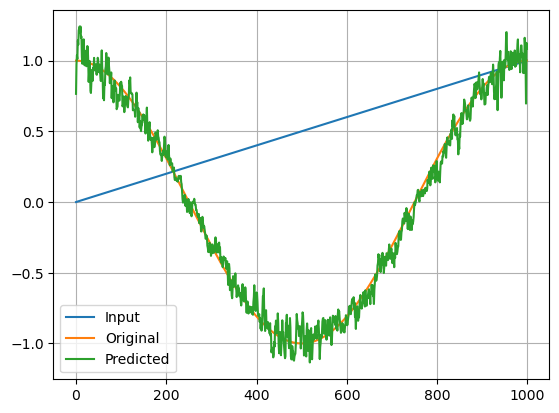

In [15]:
# Plot the original and predicted sine waves
plt.plot(input_data[0][0], label='Input')
plt.plot(target_data[0][0], label='Original')
plt.plot(predicted_data.squeeze().numpy(), label='Predicted')
plt.legend()
plt.grid()
plt.show()